In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import heapq
import matplotlib.image as mpimg
import numpy as np
from matplotlib.path import Path
from matplotlib.patches import PathPatch
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

# Updated graph with new weights
graph = {
    1: {2: 6, 3: 2, 5: 1},
    2: {1: 6, 3: 5, 4: 1},
    3: {1: 2, 2: 3, 4: 1},
    4: {2: 1, 3: 4, 5: 2},
    5: {1: 1, 4: 2}
}

# Create the networkx graph with updated weights
G = nx.Graph()
for node, neighbors in graph.items():
    for neighbor, weight in neighbors.items():
        G.add_edge(node, neighbor, weight=weight)

In [2]:
# Dijkstra's Algorithm
def dijkstra(graph, start):
    queue, visited, min_dist = [(0, start)], set(), {start: 0}
    prev = {start: None}
    while queue:
        (cost, node) = heapq.heappop(queue)
        if node not in visited:
            visited.add(node)
            for neighbor, weight in graph[node].items():
                new_cost = cost + weight
                if neighbor not in min_dist or new_cost < min_dist[neighbor]:
                    min_dist[neighbor] = new_cost
                    heapq.heappush(queue, (new_cost, neighbor))
                    prev[neighbor] = node
    return min_dist, prev

In [3]:
# Function to reconstruct the path from the predecessor dictionary
def get_path(prev, start, end):
    path = []
    while end is not None:
        path.append(end)
        end = prev[end]
    path.reverse()
    return path

In [4]:
# Comppute Dijkstra's shortest paths from node 1
shortest_paths, prev = dijkstra(graph, 1)
print("Shortest paths:", shortest_paths)

Shortest paths: {1: 0, 2: 4, 3: 2, 5: 1, 4: 3}


In [5]:
# Create a combined path to visit all nodes
all_nodes = list(graph.keys())
combined_path = []

# Start at node 1
current_node = 1
visited_nodes = set()

while len(visited_nodes) < len(all_nodes):
    shortest_paths, prev = dijkstra(graph, current_node)
    next_node = min((node for node in all_nodes if node not in visited_nodes), key=lambda x: shortest_paths[x])
    path_segment = get_path(prev, current_node, next_node)

    if combined_path:
        combined_path.extend(path_segment[1:])
    else:
        combined_path.extend(path_segment)

    visited_nodes.update(path_segment)
    current_node = next_node

print("Combined Path:", combined_path)

Combined Path: [1, 5, 4, 2, 3]


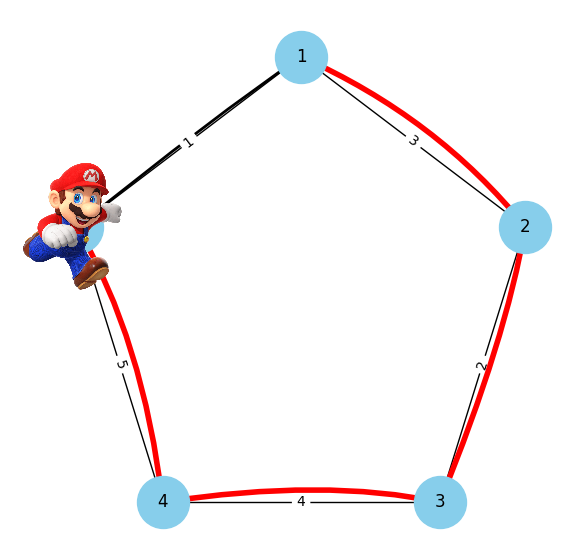

In [11]:
import requests
from PIL import Image
from io import BytesIO
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib.patches import PathPatch
from matplotlib.path import Path
import matplotlib.animation as animation

# Visualization with 2D Graph
fig, ax = plt.subplots(figsize=(7, 7))  # Increase figsize to adjust layout size

# Set positions manually to form a pentagon
pos = {
    1: (0, 1),
    2: (np.sin(2 * np.pi / 5), np.cos(2 * np.pi / 5)),
    3: (np.sin(4 * np.pi / 5), -np.cos(np.pi / 5)),
    4: (-np.sin(4 * np.pi / 5), -np.cos(np.pi / 5)),
    5: (-np.sin(2 * np.pi / 5), np.cos(2 * np.pi / 5))
}

# Create a sample graph for demonstration
G = nx.Graph()
edges = [(1, 2, 3), (2, 3, 2), (3, 4, 4), (4, 5, 5), (5, 1, 1)]
G.add_weighted_edges_from(edges)
labels = nx.get_edge_attributes(G, 'weight')

# Function to draw curved edges
def draw_curved_edges(ax, G, pos):
    for (u, v, d) in G.edges(data=True):
        u_pos = np.array(pos[u])
        v_pos = np.array(pos[v])
        control_point = (u_pos + v_pos) / 2 + np.array([0.1, 0.1])  # Control point for curve
        path_data = [
            (Path.MOVETO, pos[u]),
            (Path.CURVE3, control_point),
            (Path.CURVE3, pos[v])
        ]
        codes, verts = zip(*path_data)
        path = Path(verts, codes)
        patch = PathPatch(path, facecolor='none', edgecolor='black', linewidth=2)
        ax.add_patch(patch)

def draw_nodes(ax, pos):
    nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=1400, ax=ax)  # Increased node_size

# Function to draw the entire graph
def draw_graph(ax, G, pos):
    draw_nodes(ax, pos)
    draw_curved_edges(ax, G, pos)
    nx.draw_networkx_edge_labels(G, pos, edge_labels=labels, ax=ax)

# Load the Mario image from a URL
url = "https://static.wikia.nocookie.net/pure-good-wiki/images/3/3e/MPSS_Mario.png/revision/latest?cb=20220321075648"
response = requests.get(url)
img = Image.open(BytesIO(response.content))

# Function to mark the path
def mark_path(ax, path, pos):
    for i in range(len(path)-1):
        u_pos = np.array(pos[path[i]])
        v_pos = np.array(pos[path[i+1]])
        control_point = (u_pos + v_pos) / 2 + np.array([0.1, 0.1])  # Control point for curve
        path_data = [
            (Path.MOVETO, pos[path[i]]),
            (Path.CURVE3, control_point),
            (Path.CURVE3, pos[path[i+1]])
        ]
        codes, verts = zip(*path_data)
        path_patch = Path(verts, codes)
        patch = PathPatch(path_patch, facecolor='none', edgecolor='red', linewidth=4)
        ax.add_patch(patch)

# Example path
combined_path = [1, 2, 3, 4, 5]

def update(num):
    ax.clear()
    draw_graph(ax, G, pos)
    mark_path(ax, combined_path[:num+1], pos)
    if num < len(combined_path):
        x, y = pos[combined_path[num]]
        imagebox = OffsetImage(img, zoom=0.1)
        ab = AnnotationBbox(imagebox, (x, y), frameon=False)
        ax.add_artist(ab)
    return ax,

# Create the animation
ani = animation.FuncAnimation(fig, update, frames=len(combined_path), blit=False, interval=1000)
ani.save('dijkstra_animation.gif', writer='pillow')  # Save as GIF using Pillow writer
plt.show()
